/tmp/ipython-input-2894627844.py:24: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("movies_metadata.csv")
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:51:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:51:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:51:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:51:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


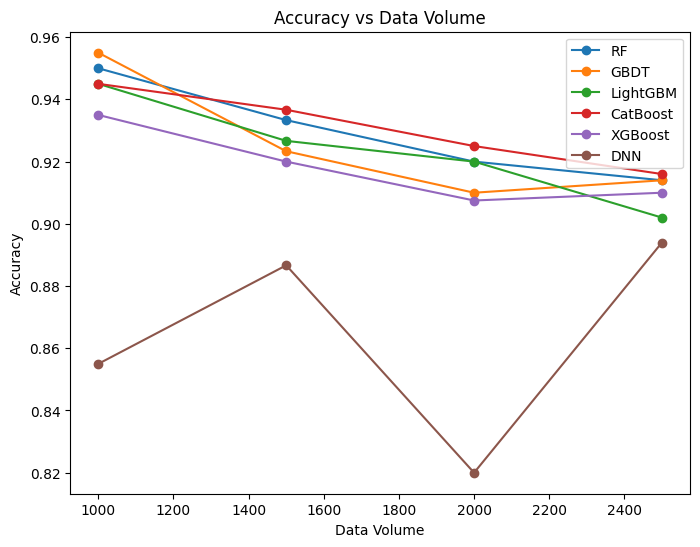

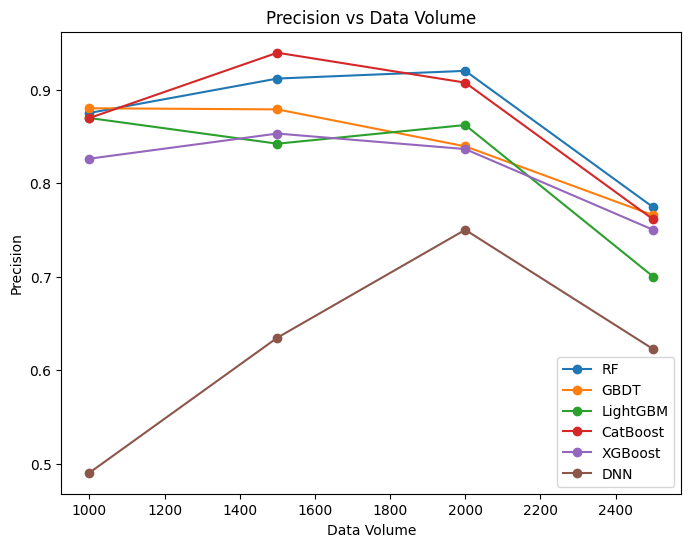

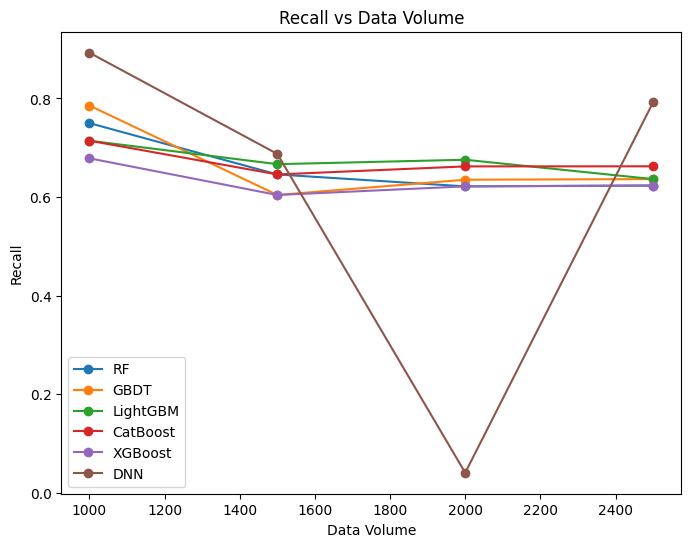

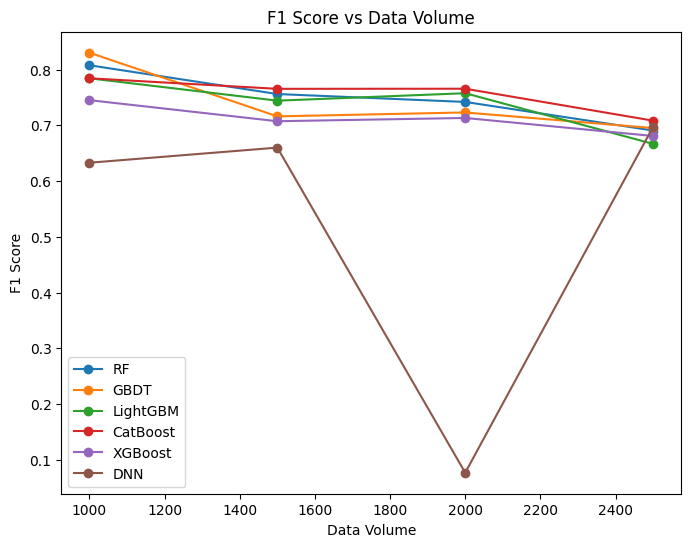

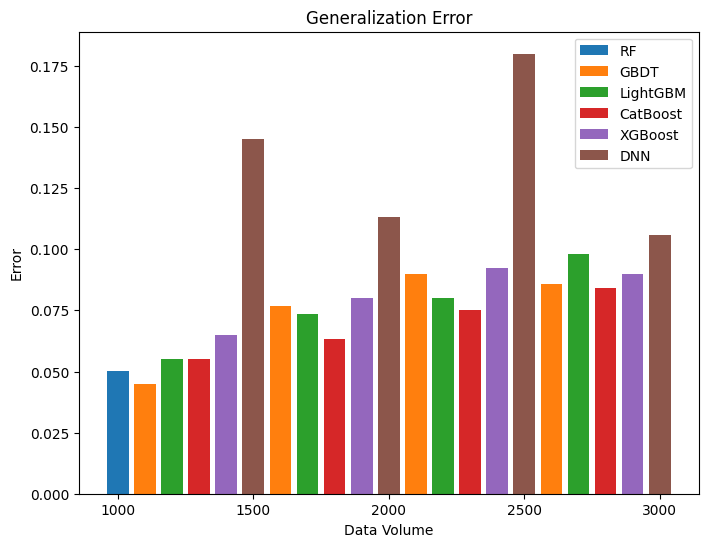

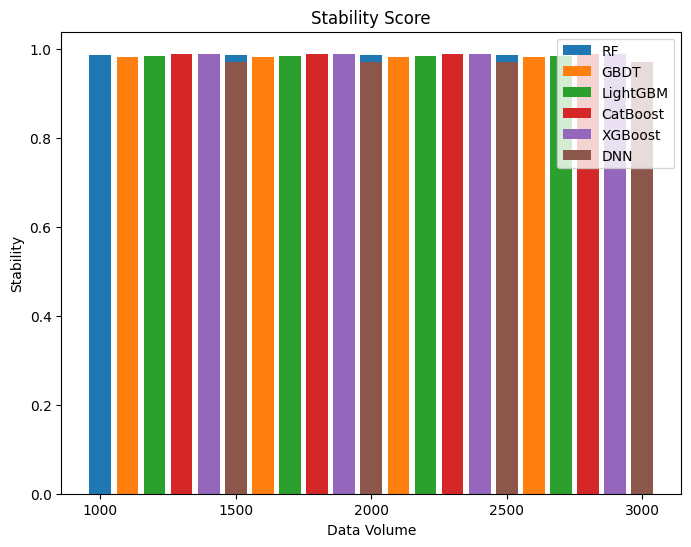

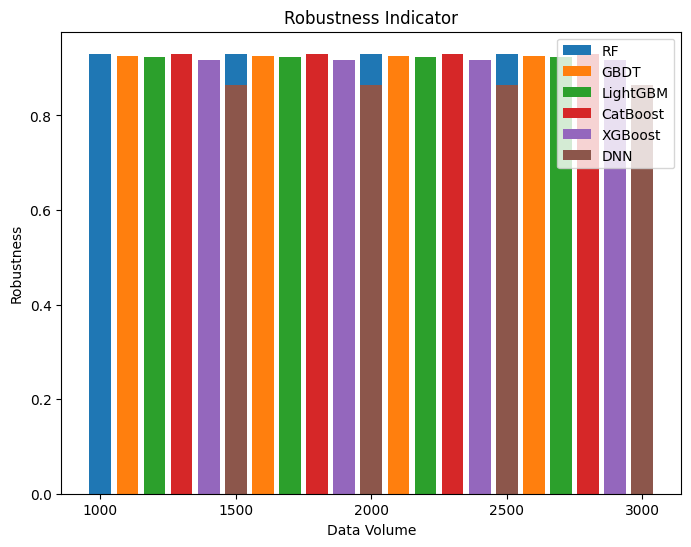

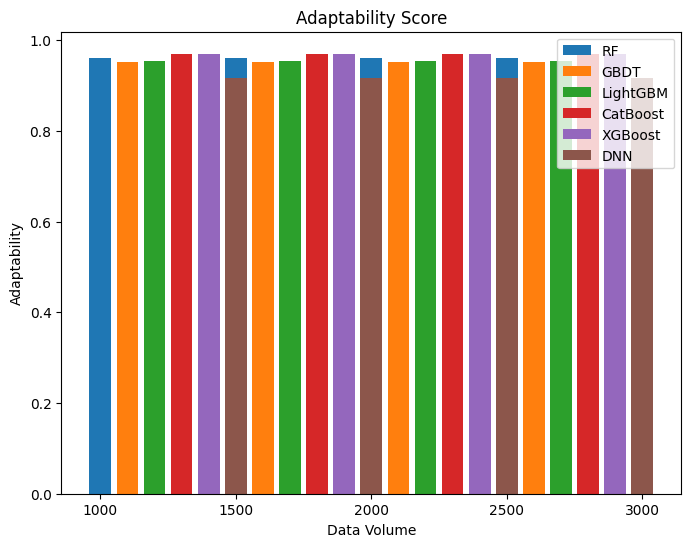

In [ ]:
# ================================
# 0. 安装依赖
# ================================
!pip install -q catboost lightgbm xgboost tensorflow

# ================================
# 1. 导入库
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ================================
# 2. 数据读取与处理
# ================================
df = pd.read_csv("movies_metadata.csv")

# 转数值型
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

# 目标变量：二分类 (票房是否超过中位数)
df = df[['budget','runtime','popularity','vote_average','vote_count','release_year','revenue']].dropna()
median_rev = df['revenue'].median()
df['target'] = (df['revenue'] > median_rev).astype(int)

X = df.drop(columns=['revenue','target'])
y = df['target']

# 填充缺失
X = X.fillna(0)

# ================================
# 3. 定义模型
# ================================
models = {
    "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    "GBDT": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "DNN": "keras"
}

# ================================
# 4. 实验数据量
# ================================
sample_sizes = [1000, 1500, 2000, 2500]
results = {m: {"accuracy":[], "precision":[], "recall":[], "f1":[]} for m in models}

for size in sample_sizes:
    X_sub, _, y_sub, _ = train_test_split(X, y, train_size=size, stratify=y, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

    for name, model in models.items():
        if name == "DNN":
            model = Sequential([
                Dense(64, activation='relu', input_shape=(X.shape[1],)),
                Dense(32, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
            y_pred = (model.predict(X_test) > 0.5).astype(int).ravel()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        results[name]["accuracy"].append(accuracy_score(y_test, y_pred))
        results[name]["precision"].append(precision_score(y_test, y_pred))
        results[name]["recall"].append(recall_score(y_test, y_pred))
        results[name]["f1"].append(f1_score(y_test, y_pred))

# ================================
# 5. 额外指标 (Fig.6)
# ================================
extra_metrics = {m: {"gen_error":[], "stability":[], "robustness":[], "adaptability":[]} for m in models}

for name in models:
    acc = np.array(results[name]["accuracy"])
    extra_metrics[name]["gen_error"] = 1 - acc
    extra_metrics[name]["stability"] = 1 - np.std(acc)
    extra_metrics[name]["robustness"] = np.mean(acc)
    extra_metrics[name]["adaptability"] = np.min(acc) / np.max(acc)

# ================================
# 6. 绘图函数
# ================================
def plot_metric(metric, title, ylabel, style='line'):
    plt.figure(figsize=(8,6))
    for name in models:
        if style == 'line':
            plt.plot(sample_sizes, results[name][metric], marker='o', label=name)
        else:
            plt.bar([s + 50*i for s in sample_sizes], extra_metrics[name][metric], width=50, label=name)
    plt.title(title)
    plt.xlabel("Data Volume")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# ================================
# 7. 画图 Fig.5 (四张折线图)
# ================================
plot_metric("accuracy", "Accuracy vs Data Volume", "Accuracy", style='line')
plot_metric("precision", "Precision vs Data Volume", "Precision", style='line')
plot_metric("recall", "Recall vs Data Volume", "Recall", style='line')
plot_metric("f1", "F1 Score vs Data Volume", "F1 Score", style='line')

# ================================
# 8. 画图 Fig.6 (四张柱状图)
# ================================
for metric, title, ylabel in [
    ("gen_error","Generalization Error","Error"),
    ("stability","Stability Score","Stability"),
    ("robustness","Robustness Indicator","Robustness"),
    ("adaptability","Adaptability Score","Adaptability")
]:
    plt.figure(figsize=(8,6))
    for i, name in enumerate(models):
        plt.bar([s + i*100 for s in sample_sizes], extra_metrics[name][metric], width=80, label=name)
    plt.title(title)
    plt.xlabel("Data Volume")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
